In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import seaborn as sns     #seaborn画出的图更好看，且代码更简单，缺点是可塑性差
from statsmodels.graphics.tsaplots import plot_acf  #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf    #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox    #白噪声检验
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from torch.autograd import Variable
from sklearn import metrics


In [2]:
data = pd.read_csv('./Data/datafull.csv',index_col= 'time')

定义滑动窗口

In [3]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length),:]
        _y = [data[i+seq_length,0]]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

以PM2.5为例子

In [4]:
df =  pd.DataFrame(data[['NO2']])

<AxesSubplot:xlabel='time'>

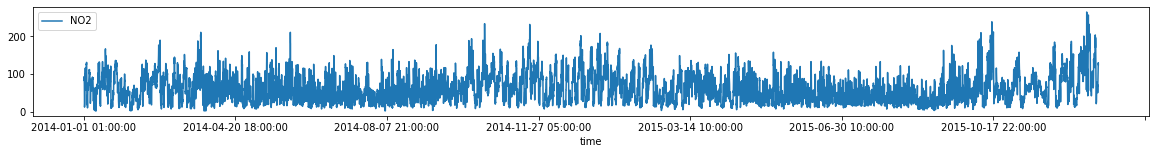

In [8]:
df.plot(figsize = (20,2))

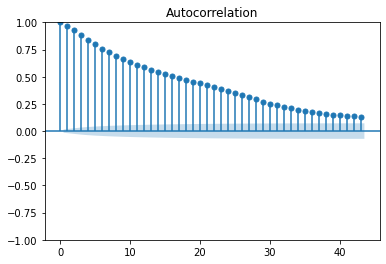

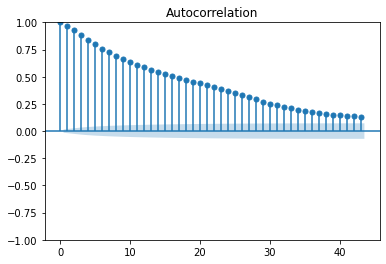

In [6]:
plot_acf(df)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [51]:
sc = StandardScaler()
sc.fit(df)
training_data = sc.transform(df)
#training_data = sc.fit_transform(df)

seq_length = 8
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) *0.9)
test_size = len(y) - train_size

dataX = (torch.Tensor(np.array(x)))
dataY = (torch.Tensor(np.array(y)))

trainX = (torch.Tensor(np.array(x[0:train_size])))
trainY = (torch.Tensor(np.array(y[0:train_size])))

testX = (torch.Tensor(np.array(x[train_size:len(x)])))
testY = (torch.Tensor(np.array(y[train_size:len(y)])))

定义model

In [17]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers,device):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.device = device

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        h_0 = (torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(self.device)
        
        c_0 = (torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(self.device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)

        out = self.relu(out)
        out = self.fc(out)
        
        return out

In [53]:
num_epochs = 2000
learning_rate = 0.0005

input_size = 1
hidden_size = 256
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers,device)
lstm = lstm.to(device)

trainX = trainX.to(device)
trainY = trainY.to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.93800
Epoch: 100, loss: 0.11783
Epoch: 200, loss: 0.10251
Epoch: 300, loss: 0.10206
Epoch: 400, loss: 0.10196
Epoch: 500, loss: 0.10187
Epoch: 600, loss: 0.10177
Epoch: 700, loss: 0.10166
Epoch: 800, loss: 0.10153
Epoch: 900, loss: 0.10135
Epoch: 1000, loss: 0.10116
Epoch: 1100, loss: 0.10101
Epoch: 1200, loss: 0.10079
Epoch: 1300, loss: 0.10063
Epoch: 1400, loss: 0.10068
Epoch: 1500, loss: 0.10029
Epoch: 1600, loss: 0.10011
Epoch: 1700, loss: 0.09996
Epoch: 1800, loss: 0.09973
Epoch: 1900, loss: 0.09957


Text(0.5, 0.98, 'Time-Series Prediction')

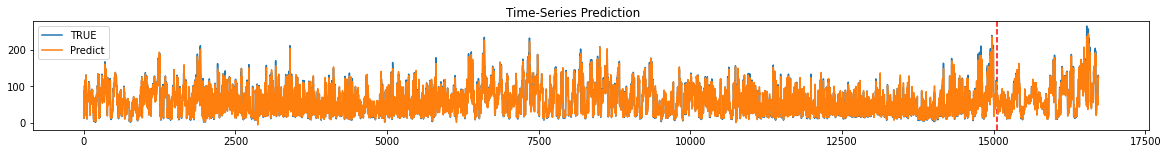

In [58]:
lstm.eval()
train_predict = lstm(dataX.to(device))

data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

#data_predict = data_predict*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
#dataY_plot = dataY*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
data_predict = data_predict*sc.scale_[0]+sc.mean_[0]
dataY_plot = dataY*sc.scale_[0]+sc.mean_[0]

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20, 2))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series Prediction')


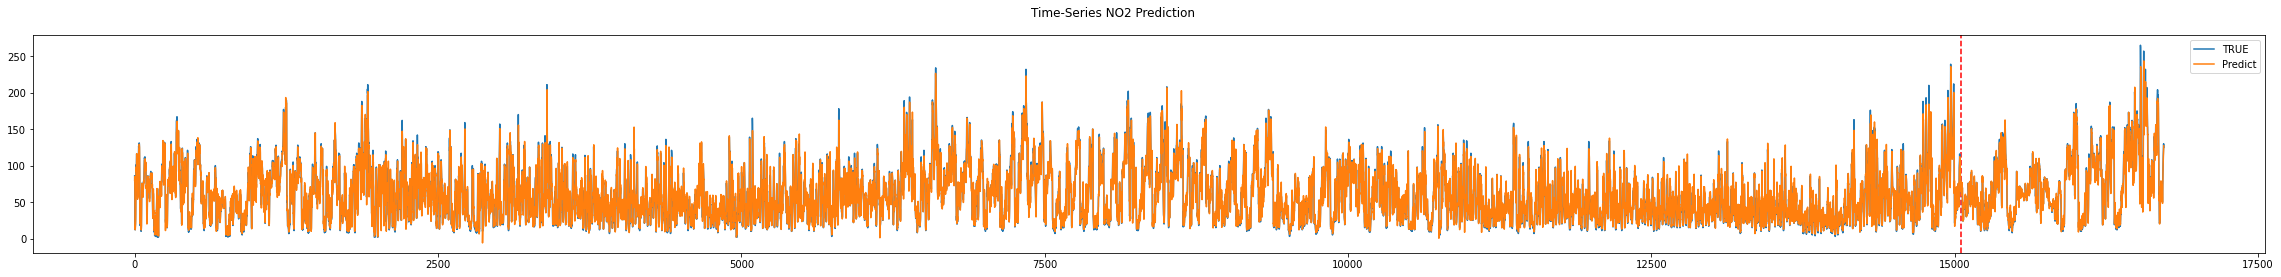

In [59]:
plt.figure(figsize=(40, 4))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_0.9.png')

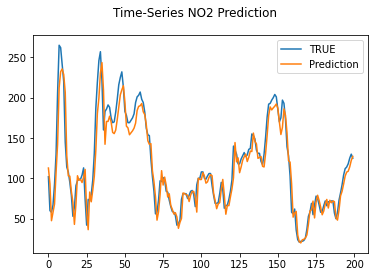

In [60]:
plt.plot(dataY_plot[-200:],label='TRUE')
plt.plot(data_predict[-200:],label='Prediction')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_0.9_2.png')

In [61]:
metrics.mean_squared_error(dataY_plot,data_predict)**0.5

11.750413603300643

In [14]:
# 先预测后一个值
for i in range(10):
    temp_X = training_data[-seq_length:,:]
    training_data =np.append(training_data,lstm(torch.Tensor(np.array([temp_X])).to(device)).cpu().data.numpy(),axis=0)

In [15]:
sc.inverse_transform(training_data)[-10:]

array([[224.79915729],
       [221.19748072],
       [212.84930964],
       [202.04715652],
       [192.38347594],
       [185.5303895 ],
       [181.88602947],
       [180.80092184],
       [181.16502154],
       [182.08110856]])

In [79]:
# 多元
df = pd.DataFrame(data[['NO2','TEMP','PRES','RAIN','HUMI','EWS','NWS']])
sc = StandardScaler()
sc.fit(df)
training_data = sc.transform(df)
#training_data = sc.fit_transform(df)

seq_length = 8
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) *0.9)
test_size = len(y) - train_size

dataX = (torch.Tensor(np.array(x)))
dataY = (torch.Tensor(np.array(y)))

trainX = (torch.Tensor(np.array(x[0:train_size])))
trainY = (torch.Tensor(np.array(y[0:train_size])))

testX = (torch.Tensor(np.array(x[train_size:len(x)])))
testY = (torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.0005

input_size = 7
hidden_size = 256
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers,device)
lstm = lstm.to(device)

trainX = trainX.to(device)
trainY = trainY.to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
#metrics.mean_squared_error(dataY_plot,data_predict)**0.5
# 先预测后一个值


Epoch: 0, loss: 0.92209
Epoch: 100, loss: 0.09653
Epoch: 200, loss: 0.08808
Epoch: 300, loss: 0.08604
Epoch: 400, loss: 0.08440
Epoch: 500, loss: 0.08282
Epoch: 600, loss: 0.08147
Epoch: 700, loss: 0.07972
Epoch: 800, loss: 0.07788
Epoch: 900, loss: 0.07836
Epoch: 1000, loss: 0.07553
Epoch: 1100, loss: 0.07286
Epoch: 1200, loss: 0.07074
Epoch: 1300, loss: 0.06846
Epoch: 1400, loss: 0.06609
Epoch: 1500, loss: 0.06444
Epoch: 1600, loss: 0.06080
Epoch: 1700, loss: 0.05730
Epoch: 1800, loss: 0.05398
Epoch: 1900, loss: 0.05137


Text(0.5, 0.98, 'Time-Series Prediction')

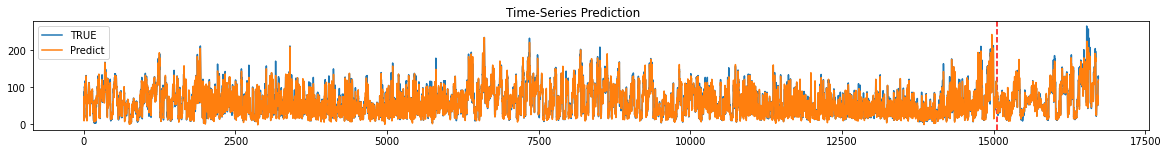

In [80]:
lstm.eval()
train_predict = lstm(dataX.to(device))

data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

#data_predict = data_predict*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
#dataY_plot = dataY*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
data_predict = data_predict*sc.scale_[0]+sc.mean_[0]
dataY_plot = dataY*sc.scale_[0]+sc.mean_[0]

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20, 2))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series Prediction')


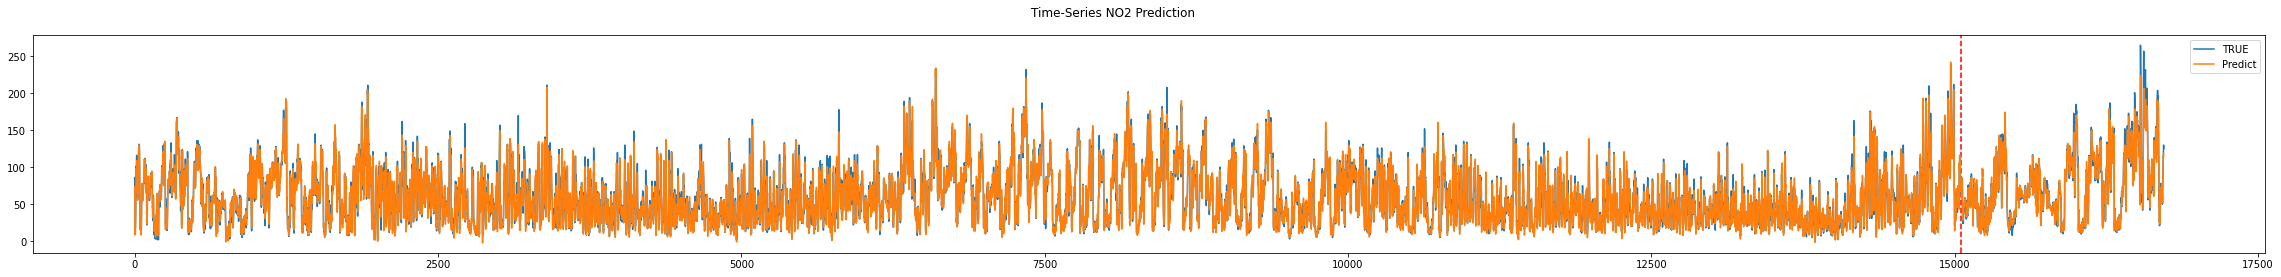

In [81]:
plt.figure(figsize=(40, 4))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_multi_0.9.png')

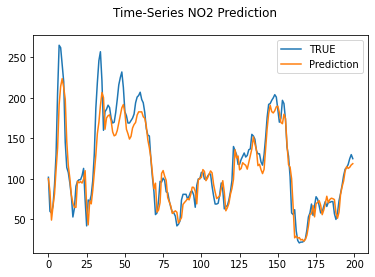

In [82]:
plt.plot(dataY_plot[-200:],label='TRUE')
plt.plot(data_predict[-200:],label='Prediction')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_multi_0.9_2.png')

In [83]:
metrics.mean_squared_error(dataY_plot,data_predict)**0.5

8.48226919438632

Single

In [16]:
data1 = pd.read_csv('./Data/datafull.csv',index_col='time')

In [17]:
for i in range(10):
    data1.loc[len(data1)] = 0
    data1.index= data1.index[:-2].append(pd.date_range(data1.index[-2],periods=2,freq='H'))

In [18]:
data1.drop(columns=['WD', 'WS'],inplace= True)

In [19]:
for names in data1.columns:
    df = pd.DataFrame(data[[names]])
    sc = StandardScaler()
    sc.fit(df)
    training_data = sc.transform(df)
    #training_data = sc.fit_transform(df)

    seq_length = 8
    x, y = sliding_windows(training_data, seq_length)

    train_size = int(len(y) *1)
    test_size = len(y) - train_size

    dataX = (torch.Tensor(np.array(x)))
    dataY = (torch.Tensor(np.array(y)))

    trainX = (torch.Tensor(np.array(x[0:train_size])))
    trainY = (torch.Tensor(np.array(y[0:train_size])))

    testX = (torch.Tensor(np.array(x[train_size:len(x)])))
    testY = (torch.Tensor(np.array(y[train_size:len(y)])))
    num_epochs = 2000
    learning_rate = 0.0005

    input_size = 1
    hidden_size = 256
    num_layers = 1

    num_classes = 1

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers,device)
    lstm = lstm.to(device)

    trainX = trainX.to(device)
    trainY = trainY.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    metrics.mean_squared_error(dataY_plot,data_predict)**0.5
    # 先预测后一个值
    for i in range(10):
        temp_X = training_data[-seq_length:,:]
        training_data =np.append(training_data,lstm(torch.Tensor(np.array([temp_X])).to(device)).cpu().data.numpy(),axis=0)
    predict = sc.inverse_transform(training_data)[-10:]
    data1[names][-10:] = predict[-10:,0]

/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00630
Epoch: 100, loss: 0.08178
Epoch: 200, loss: 0.05579
Epoch: 300, loss: 0.05498
Epoch: 400, loss: 0.05472
Epoch: 500, loss: 0.05515
Epoch: 600, loss: 0.05440
Epoch: 700, loss: 0.05432
Epoch: 800, loss: 0.05408
Epoch: 900, loss: 0.05412
Epoch: 1000, loss: 0.05366
Epoch: 1100, loss: 0.05347
Epoch: 1200, loss: 0.05326
Epoch: 1300, loss: 0.05294
Epoch: 1400, loss: 0.05252
Epoch: 1500, loss: 0.05217
Epoch: 1600, loss: 0.05191
Epoch: 1700, loss: 0.05175
Epoch: 1800, loss: 0.05147
Epoch: 1900, loss: 0.05125


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00894
Epoch: 100, loss: 0.12225
Epoch: 200, loss: 0.10524
Epoch: 300, loss: 0.10419
Epoch: 400, loss: 0.10364
Epoch: 500, loss: 0.10329
Epoch: 600, loss: 0.10292
Epoch: 700, loss: 0.10241
Epoch: 800, loss: 0.10201
Epoch: 900, loss: 0.10151
Epoch: 1000, loss: 0.10104
Epoch: 1100, loss: 0.10059
Epoch: 1200, loss: 0.10043
Epoch: 1300, loss: 0.09907
Epoch: 1400, loss: 0.09838
Epoch: 1500, loss: 0.09709
Epoch: 1600, loss: 0.09570
Epoch: 1700, loss: 0.09439
Epoch: 1800, loss: 0.09335
Epoch: 1900, loss: 0.09325


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00459
Epoch: 100, loss: 0.09094
Epoch: 200, loss: 0.05397
Epoch: 300, loss: 0.05501
Epoch: 400, loss: 0.05309
Epoch: 500, loss: 0.05295
Epoch: 600, loss: 0.05283
Epoch: 700, loss: 0.05299
Epoch: 800, loss: 0.05262
Epoch: 900, loss: 0.05256
Epoch: 1000, loss: 0.05255
Epoch: 1100, loss: 0.05243
Epoch: 1200, loss: 0.05264
Epoch: 1300, loss: 0.05271
Epoch: 1400, loss: 0.05232
Epoch: 1500, loss: 0.05241
Epoch: 1600, loss: 0.05293
Epoch: 1700, loss: 0.05212
Epoch: 1800, loss: 0.05222
Epoch: 1900, loss: 0.05199


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.01215
Epoch: 100, loss: 0.11279
Epoch: 200, loss: 0.10002
Epoch: 300, loss: 0.09983
Epoch: 400, loss: 0.09972
Epoch: 500, loss: 0.10001
Epoch: 600, loss: 0.09948
Epoch: 700, loss: 0.09939
Epoch: 800, loss: 0.09933
Epoch: 900, loss: 0.09917
Epoch: 1000, loss: 0.09898
Epoch: 1100, loss: 0.09878
Epoch: 1200, loss: 0.09862
Epoch: 1300, loss: 0.09835
Epoch: 1400, loss: 0.09870
Epoch: 1500, loss: 0.09795
Epoch: 1600, loss: 0.09778
Epoch: 1700, loss: 0.09756
Epoch: 1800, loss: 0.09728
Epoch: 1900, loss: 0.09703


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.01701
Epoch: 100, loss: 0.07817
Epoch: 200, loss: 0.06191
Epoch: 300, loss: 0.05996
Epoch: 400, loss: 0.05890
Epoch: 500, loss: 0.05811
Epoch: 600, loss: 0.05721
Epoch: 700, loss: 0.05691
Epoch: 800, loss: 0.05640
Epoch: 900, loss: 0.05600
Epoch: 1000, loss: 0.05569
Epoch: 1100, loss: 0.05545
Epoch: 1200, loss: 0.05514
Epoch: 1300, loss: 0.05481
Epoch: 1400, loss: 0.05449
Epoch: 1500, loss: 0.05419
Epoch: 1600, loss: 0.05391
Epoch: 1700, loss: 0.05368
Epoch: 1800, loss: 0.05347
Epoch: 1900, loss: 0.05341


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00732
Epoch: 100, loss: 0.10553
Epoch: 200, loss: 0.08853
Epoch: 300, loss: 0.08719
Epoch: 400, loss: 0.08588
Epoch: 500, loss: 0.08457
Epoch: 600, loss: 0.08286
Epoch: 700, loss: 0.08094
Epoch: 800, loss: 0.07954
Epoch: 900, loss: 0.07851
Epoch: 1000, loss: 0.07762
Epoch: 1100, loss: 0.07682
Epoch: 1200, loss: 0.07586
Epoch: 1300, loss: 0.07499
Epoch: 1400, loss: 0.07512
Epoch: 1500, loss: 0.07539
Epoch: 1600, loss: 0.07183
Epoch: 1700, loss: 0.07060
Epoch: 1800, loss: 0.07163
Epoch: 1900, loss: 0.06813


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.01271
Epoch: 100, loss: 0.07298
Epoch: 200, loss: 0.01886
Epoch: 300, loss: 0.01374
Epoch: 400, loss: 0.01080
Epoch: 500, loss: 0.01126
Epoch: 600, loss: 0.00962
Epoch: 700, loss: 0.00944
Epoch: 800, loss: 0.00914
Epoch: 900, loss: 0.01709
Epoch: 1000, loss: 0.00902
Epoch: 1100, loss: 0.00899
Epoch: 1200, loss: 0.00896
Epoch: 1300, loss: 0.00970
Epoch: 1400, loss: 0.00893
Epoch: 1500, loss: 0.00891
Epoch: 1600, loss: 0.00889
Epoch: 1700, loss: 0.00887
Epoch: 1800, loss: 0.00886
Epoch: 1900, loss: 0.00883


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.99611
Epoch: 100, loss: 0.03808
Epoch: 200, loss: 0.02103
Epoch: 300, loss: 0.01422
Epoch: 400, loss: 0.01244
Epoch: 500, loss: 0.01216
Epoch: 600, loss: 0.01211
Epoch: 700, loss: 0.01207
Epoch: 800, loss: 0.01205
Epoch: 900, loss: 0.01202
Epoch: 1000, loss: 0.01200
Epoch: 1100, loss: 0.01198
Epoch: 1200, loss: 0.01199
Epoch: 1300, loss: 0.01196
Epoch: 1400, loss: 0.01194
Epoch: 1500, loss: 0.01194
Epoch: 1600, loss: 0.01214
Epoch: 1700, loss: 0.01192
Epoch: 1800, loss: 0.01264
Epoch: 1900, loss: 0.01191


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00290
Epoch: 100, loss: 0.82118
Epoch: 200, loss: 0.78494
Epoch: 300, loss: 0.73760
Epoch: 400, loss: 0.66583
Epoch: 500, loss: 0.61465
Epoch: 600, loss: 0.54581
Epoch: 700, loss: 0.52523
Epoch: 800, loss: 0.51069
Epoch: 900, loss: 0.50090
Epoch: 1000, loss: 0.48839
Epoch: 1100, loss: 0.47451
Epoch: 1200, loss: 0.46545
Epoch: 1300, loss: 0.45665
Epoch: 1400, loss: 0.45092
Epoch: 1500, loss: 0.44711
Epoch: 1600, loss: 0.44386
Epoch: 1700, loss: 0.44046
Epoch: 1800, loss: 0.43977
Epoch: 1900, loss: 0.43679


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.99488
Epoch: 100, loss: 0.06509
Epoch: 200, loss: 0.05380
Epoch: 300, loss: 0.05181
Epoch: 400, loss: 0.05171
Epoch: 500, loss: 0.05168
Epoch: 600, loss: 0.05165
Epoch: 700, loss: 0.05161
Epoch: 800, loss: 0.05158
Epoch: 900, loss: 0.05154
Epoch: 1000, loss: 0.05142
Epoch: 1100, loss: 0.05137
Epoch: 1200, loss: 0.05121
Epoch: 1300, loss: 0.05143
Epoch: 1400, loss: 0.05101
Epoch: 1500, loss: 0.05090
Epoch: 1600, loss: 0.05072
Epoch: 1700, loss: 0.05058
Epoch: 1800, loss: 0.05045
Epoch: 1900, loss: 0.05033


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00045
Epoch: 100, loss: 0.04284
Epoch: 200, loss: 0.02993
Epoch: 300, loss: 0.01433
Epoch: 400, loss: 0.01020
Epoch: 500, loss: 0.00976
Epoch: 600, loss: 0.00902
Epoch: 700, loss: 0.00890
Epoch: 800, loss: 0.00887
Epoch: 900, loss: 0.00885
Epoch: 1000, loss: 0.00885
Epoch: 1100, loss: 0.00885
Epoch: 1200, loss: 0.00884
Epoch: 1300, loss: 0.00884
Epoch: 1400, loss: 0.00883
Epoch: 1500, loss: 0.00884
Epoch: 1600, loss: 0.00883
Epoch: 1700, loss: 0.00883
Epoch: 1800, loss: 0.00885
Epoch: 1900, loss: 0.00887


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.99149
Epoch: 100, loss: 0.49877
Epoch: 200, loss: 0.49545
Epoch: 300, loss: 0.49194
Epoch: 400, loss: 0.48861
Epoch: 500, loss: 0.48530
Epoch: 600, loss: 0.48315
Epoch: 700, loss: 0.48901
Epoch: 800, loss: 0.48014
Epoch: 900, loss: 0.47912
Epoch: 1000, loss: 0.47798
Epoch: 1100, loss: 0.47675
Epoch: 1200, loss: 0.47528
Epoch: 1300, loss: 0.47363
Epoch: 1400, loss: 0.47177
Epoch: 1500, loss: 0.46817
Epoch: 1600, loss: 0.46406
Epoch: 1700, loss: 0.45664
Epoch: 1800, loss: 0.44783
Epoch: 1900, loss: 0.43722


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00336
Epoch: 100, loss: 0.49894
Epoch: 200, loss: 0.49603
Epoch: 300, loss: 0.49370
Epoch: 400, loss: 0.49150
Epoch: 500, loss: 0.48975
Epoch: 600, loss: 0.48782
Epoch: 700, loss: 0.48646
Epoch: 800, loss: 0.48385
Epoch: 900, loss: 0.48132
Epoch: 1000, loss: 0.48054
Epoch: 1100, loss: 0.47861
Epoch: 1200, loss: 0.47737
Epoch: 1300, loss: 0.47547
Epoch: 1400, loss: 0.47829
Epoch: 1500, loss: 0.47156
Epoch: 1600, loss: 0.46716
Epoch: 1700, loss: 0.46136
Epoch: 1800, loss: 0.45402
Epoch: 1900, loss: 0.44325


In [20]:
data1.tail(11)

,PM2.5,PM10,SO2,NO2,O3,CO,TEMP,PRES,RAIN,HUMI,DEWP,EWS,NWS
2015-12-31 23:00:00,221.000000,231.000000,24.000000,125.000000,31.000000,4.400000,-3.400000,1025.200000,0.000000,73.000000,-7.500000,1.272792,1.272792
2016-01-01 00:00:00,223.543771,219.727835,21.945304,119.490673,28.306175,4.159470,-3.043964,1025.246145,0.018170,72.880622,-7.408354,0.781782,0.687613
2016-01-01 01:00:00,219.135190,210.561861,21.600627,114.171746,24.283207,3.886198,-2.609204,1025.169170,0.040539,72.312392,-7.339869,0.486225,0.641974
2016-01-01 02:00:00,211.582554,207.446721,21.911547,108.946923,19.809620,3.900200,-2.152905,1025.120838,0.072872,71.028769,-7.290130,0.468778,0.520923
2016-01-01 03:00:00,201.253779,212.535894,22.543402,105.034578,16.276027,4.130547,-1.754234,1025.086698,0.116530,69.319356,-7.245668,0.540777,0.488122
2016-01-01 04:00:00,190.182306,219.476676,23.351771,102.238616,13.825334,4.110341,-1.446618,1025.060677,0.170059,67.460702,-7.208546,0.473243,0.461250
2016-01-01 05:00:00,181.544075,226.164317,24.260663,100.003665,12.193127,4.021325,-1.250715,1025.034197,0.221896,65.657988,-7.176602,0.445144,0.403719
2016-01-01 06:00:00,176.628592,231.258339,25.069606,97.963701,11.181559,4.091466,-1.168829,1025.009599,0.263076,64.090358,-7.140876,0.494131,0.391322
2016-01-01 07:00:00,174.513730,234.738899,25.641991,95.867757,10.883240,4.140308,-1.169788,1024.984586,0.177013,62.778195,-7.108748,0.449656,0.482335
2016-01-01 08:00:00,173.913887,237.014367,26.028133,93.572786,11.475743,4.138135,-1.226703,1024.962573,0.269702,61.793044,-7.078552,0.497763,0.417071


In [22]:
data1.to_csv('./Data/lstm_single.csv')

In [84]:
data_single = pd.read_csv('./Data/lstm_single.csv',index_col=0)

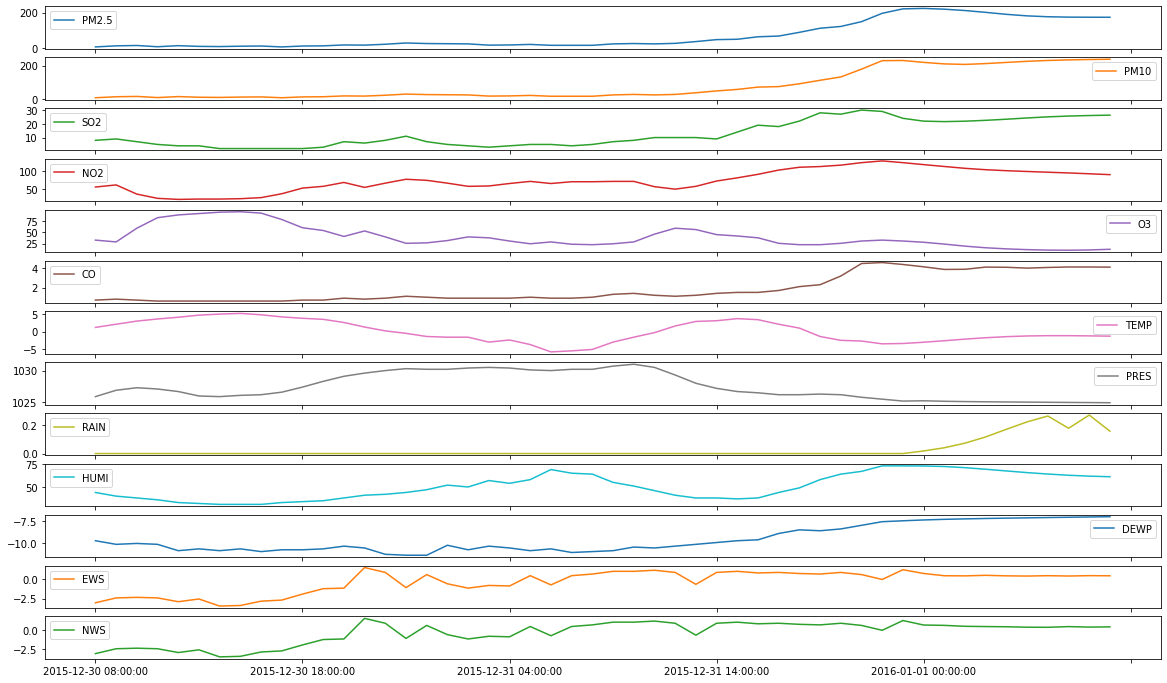

In [91]:
data_single.iloc[-50:].plot(subplots = True,figsize = (20,12))
plt.savefig('./figure/Predict_lstm.png')

COV

In [12]:
data1 = pd.read_csv('./Data/lstm_single.csv',index_col=0)

In [28]:
data2 = pd.read_csv('./Data/datafull.csv',index_col='time')

In [29]:
for i in range(10):
    data2.loc[len(data2)] = 0
    data2.index= data2.index[:-2].append(pd.date_range(data2.index[-2],periods=2,freq='H'))

In [30]:
data2.drop(columns=['WD', 'WS','DEWP','TEMP','PRES','RAIN','HUMI','EWS','NWS'],inplace= True)

In [31]:
data2

,PM2.5,PM10,SO2,NO2,O3,CO
2014-01-01 01:00:00,58.0,154.0,39.0,84.0,4.0,1.5
2014-01-01 02:00:00,68.0,162.0,39.0,85.0,4.0,1.7
2014-01-01 03:00:00,83.0,189.0,63.0,83.0,5.0,1.7
2014-01-01 04:00:00,75.0,190.0,55.0,83.0,3.0,2.1
2014-01-01 05:00:00,83.0,189.0,49.0,84.0,6.0,2.4
...,...,...,...,...,...,...
2016-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
for names in data2.columns:
    df = pd.DataFrame(data1[[names,'TEMP','PRES','RAIN','HUMI','EWS','NWS']])
    sc = StandardScaler()
    sc.fit(df)
    training_data = sc.transform(df)
    #training_data = sc.fit_transform(df)

    seq_length = 8
    x, y = sliding_windows(training_data, seq_length)

    train_size = int(len(y) *1)
    test_size = len(y) - train_size

    dataX = (torch.Tensor(np.array(x)))
    dataY = (torch.Tensor(np.array(y)))

    trainX = (torch.Tensor(np.array(x[0:-10])))
    trainY = (torch.Tensor(np.array(y[0:-10])))

    testX = (torch.Tensor(np.array(x[train_size:len(x)])))
    testY = (torch.Tensor(np.array(y[train_size:len(y)])))
    num_epochs = 2000
    learning_rate = 0.0005

    input_size = 7
    hidden_size = 256
    num_layers = 1

    num_classes = 1

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers,device)
    lstm = lstm.to(device)

    trainX = trainX.to(device)
    trainY = trainY.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    #metrics.mean_squared_error(dataY_plot,data_predict)**0.5
    # 先预测后一个值
    for i in range(10):
        temp_X = training_data[-seq_length:,:]
        training_data[len(data)+i,0] = lstm(torch.Tensor(np.array([temp_X])).to(device)).cpu().data.numpy()
    predict = sc.inverse_transform(training_data)[-10:]
    data2[names][-10:] = predict[-10:,0]

/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.99436
Epoch: 100, loss: 0.06573
Epoch: 200, loss: 0.05453
Epoch: 300, loss: 0.04905
Epoch: 400, loss: 0.04806
Epoch: 500, loss: 0.04698
Epoch: 600, loss: 0.04590
Epoch: 700, loss: 0.04480
Epoch: 800, loss: 0.04665
Epoch: 900, loss: 0.04306
Epoch: 1000, loss: 0.04207
Epoch: 1100, loss: 0.04116
Epoch: 1200, loss: 0.03997
Epoch: 1300, loss: 0.03878
Epoch: 1400, loss: 0.03749
Epoch: 1500, loss: 0.03643
Epoch: 1600, loss: 0.03580
Epoch: 1700, loss: 0.03526
Epoch: 1800, loss: 0.03255
Epoch: 1900, loss: 0.03062


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.01403
Epoch: 100, loss: 0.11235
Epoch: 200, loss: 0.09651
Epoch: 300, loss: 0.09388
Epoch: 400, loss: 0.09150
Epoch: 500, loss: 0.09021
Epoch: 600, loss: 0.08725
Epoch: 700, loss: 0.08496
Epoch: 800, loss: 0.08243
Epoch: 900, loss: 0.07955
Epoch: 1000, loss: 0.07928
Epoch: 1100, loss: 0.07418
Epoch: 1200, loss: 0.06811
Epoch: 1300, loss: 0.06370
Epoch: 1400, loss: 0.05978
Epoch: 1500, loss: 0.05532
Epoch: 1600, loss: 0.05129
Epoch: 1700, loss: 0.04871
Epoch: 1800, loss: 0.04372
Epoch: 1900, loss: 0.04076


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.99805
Epoch: 100, loss: 0.07436
Epoch: 200, loss: 0.05164
Epoch: 300, loss: 0.05036
Epoch: 400, loss: 0.05167
Epoch: 500, loss: 0.04901
Epoch: 600, loss: 0.04866
Epoch: 700, loss: 0.04773
Epoch: 800, loss: 0.04699
Epoch: 900, loss: 0.04690
Epoch: 1000, loss: 0.04521
Epoch: 1100, loss: 0.04408
Epoch: 1200, loss: 0.04263
Epoch: 1300, loss: 0.04118
Epoch: 1400, loss: 0.03948
Epoch: 1500, loss: 0.03735
Epoch: 1600, loss: 0.03535
Epoch: 1700, loss: 0.03259
Epoch: 1800, loss: 0.02959
Epoch: 1900, loss: 0.02760


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.99018
Epoch: 100, loss: 0.09813
Epoch: 200, loss: 0.08713
Epoch: 300, loss: 0.08521
Epoch: 400, loss: 0.08383
Epoch: 500, loss: 0.08252
Epoch: 600, loss: 0.08135
Epoch: 700, loss: 0.08015
Epoch: 800, loss: 0.07893
Epoch: 900, loss: 0.07760
Epoch: 1000, loss: 0.07626
Epoch: 1100, loss: 0.07493
Epoch: 1200, loss: 0.07335
Epoch: 1300, loss: 0.07158
Epoch: 1400, loss: 0.06970
Epoch: 1500, loss: 0.06777
Epoch: 1600, loss: 0.06574
Epoch: 1700, loss: 0.06358
Epoch: 1800, loss: 0.06102
Epoch: 1900, loss: 0.05841


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00377
Epoch: 100, loss: 0.06123
Epoch: 200, loss: 0.04729
Epoch: 300, loss: 0.04542
Epoch: 400, loss: 0.04430
Epoch: 500, loss: 0.04343
Epoch: 600, loss: 0.04251
Epoch: 700, loss: 0.04171
Epoch: 800, loss: 0.04081
Epoch: 900, loss: 0.03991
Epoch: 1000, loss: 0.03904
Epoch: 1100, loss: 0.03813
Epoch: 1200, loss: 0.03724
Epoch: 1300, loss: 0.03629
Epoch: 1400, loss: 0.03571
Epoch: 1500, loss: 0.03455
Epoch: 1600, loss: 0.03425
Epoch: 1700, loss: 0.03177
Epoch: 1800, loss: 0.03059
Epoch: 1900, loss: 0.02885


/home/terry/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 1.00797
Epoch: 100, loss: 0.09515
Epoch: 200, loss: 0.07821
Epoch: 300, loss: 0.07499
Epoch: 400, loss: 0.07213
Epoch: 500, loss: 0.06952
Epoch: 600, loss: 0.06694
Epoch: 700, loss: 0.06453
Epoch: 800, loss: 0.06222
Epoch: 900, loss: 0.05981
Epoch: 1000, loss: 0.05726
Epoch: 1100, loss: 0.05450
Epoch: 1200, loss: 0.05145
Epoch: 1300, loss: 0.04793
Epoch: 1400, loss: 0.04573
Epoch: 1500, loss: 0.04150
Epoch: 1600, loss: 0.03915
Epoch: 1700, loss: 0.03577
Epoch: 1800, loss: 0.03285
Epoch: 1900, loss: 0.03055


In [47]:
data2.tail(11)

,PM2.5,PM10,SO2,NO2,O3,CO
2015-12-31 23:00:00,221.000000,231.000000,24.000000,125.000000,31.000000,4.400000
2016-01-01 00:00:00,177.758479,245.540630,27.903419,96.080212,14.699512,3.961771
2016-01-01 01:00:00,177.758479,245.540630,27.903419,96.080212,14.699512,3.961771
2016-01-01 02:00:00,177.758479,245.540630,27.903419,96.080212,14.699512,3.961771
2016-01-01 03:00:00,176.315438,250.052496,28.075797,95.447885,14.711093,3.965252
2016-01-01 04:00:00,175.305888,254.431327,28.168218,95.101640,14.685018,3.957991
2016-01-01 05:00:00,174.675875,258.956001,28.128575,95.017559,14.682171,3.962240
2016-01-01 06:00:00,174.304080,263.306869,28.034150,95.029300,14.694770,3.967126
2016-01-01 07:00:00,174.505426,262.504262,27.839319,95.108047,14.686281,3.947623
2016-01-01 08:00:00,174.509413,264.232307,28.310953,95.021519,14.743730,3.877792


In [48]:
data2.to_csv('./Data/lstm_cov.csv')

In [87]:
data_cov = pd.read_csv('./Data/lstm_cov.csv',index_col=0)

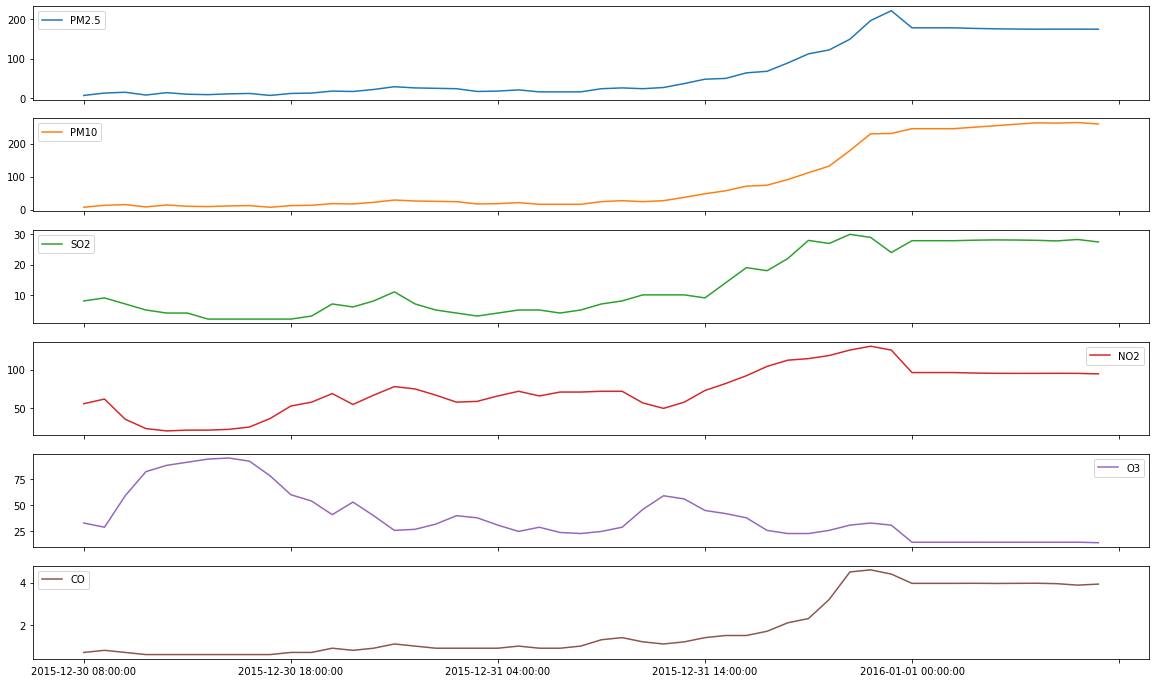

In [92]:
data_cov[-50:].plot(subplots = True,figsize = (20,12))
plt.savefig('./figure/Predict_lstm_cov.png')